In [1]:
 #Importing Libraries
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, RocCurveDisplay,roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
import string
import numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import time
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import FeatureUnion

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from pathlib import Path
train_path = Path('train.csv') 
test_path = Path('valid.csv')

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head(5)

,ArticleId,Text,Category
0,1155,chancellor rallies labour voters gordon brown ...,politics
1,1980,india s maruti sees profits jump india s bigge...,business
2,386,ukip s secret weapon by any measure new york...,politics
3,1436,banker loses sexism claim a former executive a...,business
4,304,dallaglio eyeing lions tour place former engla...,sport


In [3]:
train_df.shape

(1043, 3)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1043 non-null   int64 
 1   Text       1043 non-null   object
 2   Category   1043 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.6+ KB


In [6]:
train_df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [7]:
target_names = train_df['Category'].unique().tolist()
target_names

['politics', 'business', 'sport', 'entertainment', 'tech']

In [23]:
print(train_df.iloc[0,1])
print(train_df.iloc[30,1])
print(train_df.iloc[245,1])

chancellor rallies labour voters gordon brown issued rallying cry supporters warning stakes high stay home protest vote next general election chancellor said poll expected fall may would give clear fundamental choice labour investment tory cuts told party spring conference tories must allowed win conservatives lib dems insisted voters faced higher taxes meanstesting labour packed audience gateshead sage centre mr brown accused shadow chancellor oliver letwin plotting cuts equivalent sacking every teacher gp nurse country laying conservative record government said give promise labour britain never return mistakes erm inflation interest rates bn lost reserves repossessed one million negative equity three million unemployed never tory boom bust central dividing line election conservative party taking britain back planning deep cuts bn services labour government taking britain forward platform stability reform renew hospitals schools public services proud say spend bn turning economy chanc

In [8]:
counts = train_df['Category'].value_counts()
for col in target_names:
    col_sum = counts[col]
    print(f'Total no of {col}_is {col_sum}')

Total no of politics_is 196
Total no of business_is 235
Total no of sport_is 250
Total no of entertainment_is 178
Total no of tech_is 184


## CLEANING

In [25]:
def preprocessor(text):
    '''
    explain func
    '''
    text = text.lower() #Lowers  the text
    text = re.sub('<[^>]*>', '', text) # removes HTML Markup
    text = re.sub(r'[^a-zA-Z\s]', '', text) # removes special characters and digits
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words and word not in string.punctuation] #removes stopwords
    text = ' '.join(word for word in text)
    return text

In [24]:
train_df['Text'] = train_df['Text'].apply(preprocessor)
train_df.loc[0,'Text']

'chancellor rallies labour voters gordon brown issued rallying cry supporters warning stakes high stay home protest vote next general election chancellor said poll expected fall may would give clear fundamental choice labour investment tory cuts told party spring conference tories must allowed win conservatives lib dems insisted voters faced higher taxes meanstesting labour packed audience gateshead sage centre mr brown accused shadow chancellor oliver letwin plotting cuts equivalent sacking every teacher gp nurse country laying conservative record government said give promise labour britain never return mistakes erm inflation interest rates bn lost reserves repossessed one million negative equity three million unemployed never tory boom bust central dividing line election conservative party taking britain back planning deep cuts bn services labour government taking britain forward platform stability reform renew hospitals schools public services proud say spend bn turning economy chan

In [29]:
x_train = train_df['Text']
y_train = train_df['Category']
label_encoder = LabelEncoder()
y_train_transform = label_encoder.fit_transform(y_train)
y_train_transform.shape

(1043,)

In [12]:
tf_idf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 10)
x_train_transform = tf_idf_vectorizer.fit_transform(x_train)
print(x_train_transform.shape)
tfidf_dataframe = pd.DataFrame(x_train_transform.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
tfidf_dataframe.head()

(1043, 3085)


,ability,able,abroad,absence,absolutely,abuse,academy,accept,accepted,access,...,years,yen,yes,yet,york,young,younger,yukos,zealand,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023486,0.0,0.0,0.0,0.0,0.07663,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035921,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.047386,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.105149,0.0


### Modelling

In [ ]:

pipe = Pipeline()

In [14]:
from sklearn.svm import SVC
base_svm_model = SVC(random_state= 10, probability= True)
%time base_svm_model.fit(x_train_transform, y_train)

CPU times: user 7.78 s, sys: 23.2 ms, total: 7.8 s
Wall time: 8.01 s


SVC(probability=True, random_state=10)

In [15]:
y_pred = base_svm_model.predict(x_valid_transform)
y_pred_prob = base_svm_model.predict_proba(x_valid_transform)

In [16]:
print(len(y_pred_prob[:,4]))
print(y_pred[0])
print(base_svm_model.classes_)

223
tech
['business' 'entertainment' 'politics' 'sport' 'tech']


In [17]:
def model_score(test, pred, y_pred_prob, classes = None):
    print(f'Accuracy Score : {accuracy_score(test, pred)}')
    #auc score 
    print(f'AUC Score : {roc_auc_score(y_test, y_pred_prob, multi_class="ovr")}')
    cm = confusion_matrix(y_test, y_pred, labels= classes)
    disp = ConfusionMatrixDisplay(confusion_matrix= cm , display_labels= classes)
    fig , ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation= 'vertical')
    plt.show()


Accuracy Score : 0.968609865470852
AUC Score : 0.9988441198613323


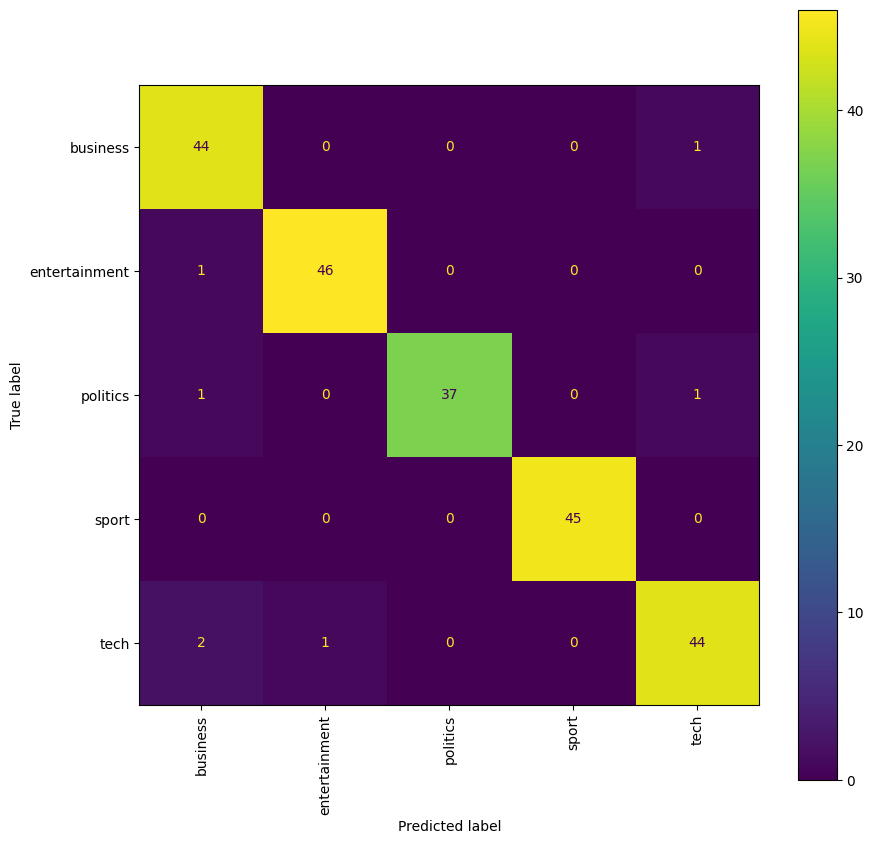

In [18]:
model_score(y_test,y_pred,y_pred_prob, classes= base_svm_model.classes_)


In [19]:
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelEncoder
#Label_encoder = LabelEncoder()
#y_test_encoded = Label_encoder.fit_transform(y_test)
visualizer = ROCAUC(base_svm_model, classes= base_svm_model.classes_, is_fitted= True)
visualizer.score(x_valid_transform, y_test)
visualizer.show()

/home/codespace/.python/current/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


YellowbrickAttributeError: neither visualizer 'ROCAUC' nor wrapped estimator 'SVC' have attribute 'target_type_'

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

X, y =load_game()
X =  OrdinalEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,y, random_state= 42)
Rmodel = RidgeClassifier()
Smodel = SVC(random_state= 42)
viz = ROCAUC(Smodel, classes= ["win", "loss", "draw"])
viz.fit(X_TRAIN,Y_TRAIN)
viz.score(X_TEST,Y_TEST)
viz.show()

# FINAL TEST

In [ ]:
def makecsv(id_test, test_y_pred):
    #change the ans label
    #test_y_pred = number_to_label(test_y_pred)
    submission = {'ArticleId': id_test, 'Category': test_y_pred}
    submission = pd.DataFrame(submission)
    submission.to_csv('./submission.csv', index=0, header=1)

In [ ]:
final_test_df = pd.read_csv('/workspaces/codespaces-blank/news_classification/data/test.csv')
final_test_df['Text'] = final_test_df['Text'].apply(preprocessor)
final_y = tf_idf_vectorizer.transform(final_test_df['Text'])
print(final_y.shape)
final_y_pred = base_svm_model.predict(final_y)
makecsv(final_test_df['ArticleId'], final_y_pred)

(224, 3085)
